## Comparing Sentinel C-Band SAR to Capella X-Band SAR (EDA Phase)

##### Step 1: Bring Sentinel Data in via the Google Earth Engine Python API and export it as a tif. The top of this repos README has instruction for how to pull data down from Capella's S3 bucket without an account.

In [ ]:
import json, numpy as np
from pyproj import Transformer
import ee, geemap, rasterio
import os

ee.Initialize(project='ee-krle4401')

# --- 1) Load Capella metadata ---
json_path = "/Users/kitlewers/Capella_SAR_Fun/capella-sar-seg/data/raw/scene_shanghai/CAPELLA_C11_SP_GEO_HH_20250320045730_20250320045802_extended.json"
with open(json_path, "r") as f:
    meta = json.load(f)

# Geotransform (UTM 51N, EPSG:32651)
gt = meta["collect"]["image"]["image_geometry"]["geotransform"]
rows = int(meta["collect"]["image"]["rows"])
cols = int(meta["collect"]["image"]["columns"])
x0, px_w, rot_x, y0, rot_y, px_h_neg = gt
px_h = abs(px_h_neg)

# Corners in UTM (no rotation for this product)
width_m  = px_w * cols
height_m = px_h * rows
corners_utm = np.array([
    [x0,             y0            ],  # TL
    [x0 + width_m,   y0            ],  # TR
    [x0 + width_m,   y0 - height_m ],  # BR
    [x0,             y0 - height_m ],  # BL
    [x0,             y0            ],  # close
], dtype=float)

# Reproject to lon/lat
transformer = Transformer.from_crs(32651, 4326, always_xy=True)
lons, lats = transformer.transform(corners_utm[:,0], corners_utm[:,1])
footprint_ll = [[float(lon), float(lat)] for lon, lat in zip(lons, lats)]
centroid_lon = float(np.mean(lons[:-1])); centroid_lat = float(np.mean(lats[:-1]))

# --- 2) Correct center time from JSON ---
# Prefer center_pixel.center_time; fall back to start/stop if needed
center_iso = (meta.get("collect", {})
                  .get("image", {})
                  .get("center_pixel", {})
                  .get("center_time"))
if center_iso is None:
    center_iso = meta["collect"]["start_timestamp"]  # safe fallback

capella_date = ee.Date(center_iso)
print("Capella center time:", center_iso)

# AOI polygon
aoi = ee.Geometry.Polygon([footprint_ll])

# --- 3) Find closest Sentinel scene (HH if available, else VV/VH) ---
window_days = 180
s1_hh = (ee.ImageCollection('COPERNICUS/S1_GRD')
         .filterBounds(aoi)
         .filterDate(capella_date.advance(-window_days,'day'),
                     capella_date.advance(window_days,'day'))
         .filter(ee.Filter.listContains('transmitterReceiverPolarisation','HH')))

def add_time_diff(img):
    return img.set('time_diff_days', img.date().difference(capella_date, 'day').abs())

s1_hh_sorted = s1_hh.map(add_time_diff).sort('time_diff_days')

if s1_hh_sorted.size().getInfo() > 0:
    s1_img  = ee.Image(s1_hh_sorted.first()); s1_band = 'HH'
    s1_vis  = {'bands':[s1_band], 'min':-25, 'max':0}
    print("Closest Sentinel‑1 HH:", s1_img.date().format().getInfo())
else:
    s1_iw = (ee.ImageCollection('COPERNICUS/S1_GRD')
             .filterBounds(aoi)
             .filterDate(capella_date.advance(-window_days,'day'),
                         capella_date.advance(window_days,'day'))
             .filter(ee.Filter.eq('instrumentMode','IW'))
             .sort('system:time_start'))
    s1_img = ee.Image(s1_iw.first())
    bands  = s1_img.bandNames().getInfo()
    s1_band = 'VV' if 'VV' in bands else 'VH'
    s1_vis  = {'bands':[s1_band],
               'min': -22 if s1_band=='VV' else -27,
               'max':   0 if s1_band=='VV' else  -5}
    print("Closest Sentinel‑1 (IW):", s1_img.date().format().getInfo(), "| Band:", s1_band)

# --- 4) Map & local Capella overlay ---
Map = geemap.Map(center=[centroid_lat, centroid_lon], zoom=13)
Map.addLayer(s1_img.select(s1_band), s1_vis, f"S1 {s1_band} (closest)")
Map.addLayer(aoi, {'color':'red'}, "Capella footprint (exact)")

capella_path = "/Users/kitlewers/Capella_SAR_Fun/capella-sar-seg/outputs/shanghai_hh_db.tif"  # adjust if needed
with rasterio.open(capella_path) as src:
    arr = src.read(1, masked=True).compressed()
    p2, p98 = np.percentile(arr, [2, 98])

Map.add_raster(capella_path, layer_name="Capella HH (local dB)",
               vmin=float(p2), vmax=float(p98), opacity=0.65)

Map.split_map(left_layer=f"S1 {s1_band} (closest)", right_layer="Capella HH (local dB)")
project_dir = "/Users/kitlewers/Capella_SAR_Fun/capella-sar-seg/outputs"
os.makedirs(project_dir, exist_ok=True)
out_html = os.path.join(project_dir, "sentinel_capella_compare.html")
Map.to_html(out_html, title="Capella vs Sentinel (aligned)", width="100%", height="820px")
print("Saved: sentinel_capella_compare.html")


#### Export Sentinel data within ROI for local analysis

In [20]:
out_tif = os.path.join(project_dir, "sentinel_capella_roi.tif")
geemap.ee_export_image(
    s1_img.select(s1_band).clip(aoi),
    filename=out_tif,
    scale=10,
    region=aoi
)


Generating URL ...
Please wait ...
Data downloaded to /Users/kitlewers/Capella_SAR_Fun/capella-sar-seg/outputs/sentinel_capella_roi.tif


#### Convert Capella to a dB product

In [3]:
import json, numpy as np, rasterio, os
from rasterio.enums import Resampling

cap_dn_path = "/Users/kitlewers/Capella_SAR_Fun/capella-sar-seg/data/raw/scene_shanghai/CAPELLA_C11_SP_GEO_HH_20250320045730_20250320045802.tif"   # the float/int image with values in thousands
cap_json    = "/Users/kitlewers/Capella_SAR_Fun/capella-sar-seg/data/raw/scene_shanghai/CAPELLA_C11_SP_GEO_HH_20250320045730_20250320045802_extended.json"
cap_db_path = "/Users/kitlewers/Capella_SAR_Fun/capella-sar-seg/outputs/capella_sigma0_db_float32.tif"

# --- parse metadata for scaling ---
with open(cap_json, "r") as f:
    meta = json.load(f)

img_meta   = meta.get("collect", {}).get("image", {})
radiometry = (img_meta.get("radiometry") or "").lower()
scale_db   = img_meta.get("scale_factor_db", None) or img_meta.get("db_per_dn", None)
offset_db  = img_meta.get("offset_db", 0.0)
scale_lin  = img_meta.get("scale_factor", None) or img_meta.get("linear_scale", None)
pixel_val  = (img_meta.get("pixel_value") or img_meta.get("pixel_units") or "").lower()

def dn_to_db(arr):
    a = arr.astype("float32")
    # NoData as NaN
    a[a == 0] = np.nan

    # Case A: explicit dB-per-DN
    if isinstance(scale_db, (int, float)) and abs(scale_db) < 1.0:
        return a * float(scale_db) + float(offset_db)

    # Case B: linear scaling provided
    if isinstance(scale_lin, (int, float)) and scale_lin > 0:
        if "ampl" in pixel_val:
            return 20.0 * np.log10(a * float(scale_lin) + 1e-12) + float(offset_db)
        # assume POWER if not amplitude
        return 10.0 * np.log10(a * float(scale_lin) + 1e-12) + float(offset_db)

    # Case C: fallback heuristic (try POWER)
    return 10.0 * np.log10(a + 1e-12)

# --- stream-convert to float32 dB GeoTIFF ---
os.makedirs(os.path.dirname(cap_db_path), exist_ok=True)
with rasterio.open(cap_dn_path) as src:
    profile = src.profile.copy()
    profile.update(dtype="float32", count=1, nodata=np.nan, compress="deflate")
    with rasterio.open(cap_db_path, "w", **profile) as dst:
        block_h = src.block_shapes[0][0] if src.is_tiled else 1024
        block_w = src.block_shapes[0][1] if src.is_tiled else 1024
        for y in range(0, src.height, block_h):
            h = min(block_h, src.height - y)
            for x in range(0, src.width, block_w):
                w = min(block_w, src.width - x)
                win = rasterio.windows.Window(x, y, w, h)
                dn = src.read(1, window=win)
                db = dn_to_db(dn)
                dst.write(db.astype("float32"), 1, window=win)

print("Wrote Capella σ⁰(dB):", cap_db_path)


Wrote Capella σ⁰(dB): /Users/kitlewers/Capella_SAR_Fun/capella-sar-seg/outputs/capella_sigma0_db_float32.tif


Even just looking between the two, the difference is staggering. ***It is worth reminding you that these are different bands. 

<p float="left">
  <img src="https://raw.githubusercontent.com/kllewers/Capella_Space_Dabbling/main/Sentinel.png" width="49%" />
  <img src="https://raw.githubusercontent.com/kllewers/Capella_Space_Dabbling/main/Sentinel_Capella.png" width="49%" />
</p>


In [5]:
import numpy as np, rasterio, os
from rasterio.enums import Resampling
from rasterio.vrt import WarpedVRT
from rasterio.windows import Window

cap_db_path = "/Users/kitlewers/Capella_SAR_Fun/capella-sar-seg/outputs/capella_sigma0_db_float32.tif"    # from step 1
s1_db_path  = "/Users/kitlewers/Capella_SAR_Fun/capella-sar-seg/outputs/sentinel_capella_roi.tif"       # your clipped S1 (dB)
stack_path  = "/Users/kitlewers/Capella_SAR_Fun/capella-sar-seg/outputs/S1_CAP_overlap_stack.tif"

BLOCK = 1024
os.makedirs(os.path.dirname(stack_path), exist_ok=True)

with rasterio.open(cap_db_path) as cap_src, rasterio.open(s1_db_path) as s1_src:
    profile = cap_src.profile.copy()
    profile.update(count=2, dtype="float32", nodata=np.nan, compress="deflate", tiled=True,
                   blockxsize=BLOCK, blockysize=BLOCK)
    with rasterio.open(stack_path, "w", **profile) as dst:
        # Present S1 in Capella's grid
        with WarpedVRT(s1_src, crs=cap_src.crs, transform=cap_src.transform,
                       width=cap_src.width, height=cap_src.height,
                       resampling=Resampling.bilinear) as s1_vrt:
            for y in range(0, cap_src.height, BLOCK):
                for x in range(0, cap_src.width, BLOCK):
                    w = Window(x, y, min(BLOCK, cap_src.width-x), min(BLOCK, cap_src.height-y))
                    cap_tile = cap_src.read(1, window=w, out_dtype="float32")
                    s1_tile  = s1_vrt.read(1, window=w, out_dtype="float32")

                    # sanity masks (exclude nodata and silly values)
                    cap_tile[cap_tile <= -60] = np.nan
                    s1_tile[s1_tile <= -60]   = np.nan

                    both = np.isfinite(cap_tile) & np.isfinite(s1_tile)
                    cap_out = np.where(both, cap_tile, np.nan).astype("float32")
                    s1_out  = np.where(both, s1_tile,  np.nan).astype("float32")

                    dst.write(s1_out, 1, window=w)
                    dst.write(cap_out, 2, window=w)

print("Wrote overlap stack:", stack_path, "(band1=S1 dB, band2=Capella dB)")


Wrote overlap stack: /Users/kitlewers/Capella_SAR_Fun/capella-sar-seg/outputs/S1_CAP_overlap_stack.tif (band1=S1 dB, band2=Capella dB)


![Overlap](https://raw.githubusercontent.com/kllewers/Capella_Space_Dabbling/main/Sentinel_Capella_Pixel_Overlap.png)

In [6]:
import numpy as np, rasterio
from rasterio.windows import Window

step = 20  # sample every 20 px each way
vals = []

with rasterio.open(stack_path) as src:
    H, W = src.height, src.width
    for y in range(0, H, step):
        h = min(step, H - y)
        for x in range(0, W, step):
            w = min(step, W - x)
            win = Window(x, y, w, h)
            s1 = src.read(1, window=win)
            ca = src.read(2, window=win)
            mask = np.isfinite(s1) & np.isfinite(ca)
            if mask.any():
                vals.append(np.column_stack([s1[mask], ca[mask]]))

arr = np.vstack(vals) if vals else np.empty((0,2), dtype="float32")
print("Sampled overlapping pixels:", arr.shape[0])
if arr.size:
    print("S1 mean (dB):", float(arr[:,0].mean()))
    print("Capella mean (dB):", float(arr[:,1].mean()))
    # optional: quick correlation
    corr = np.corrcoef(arr[:,0], arr[:,1])[0,1]
    print("Pearson r:", float(corr))


Sampled overlapping pixels: 633868266
S1 mean (dB): -5.172057628631592
Capella mean (dB): -0.7330946326255798
Pearson r: 0.3705372881061724


#### Visualize results

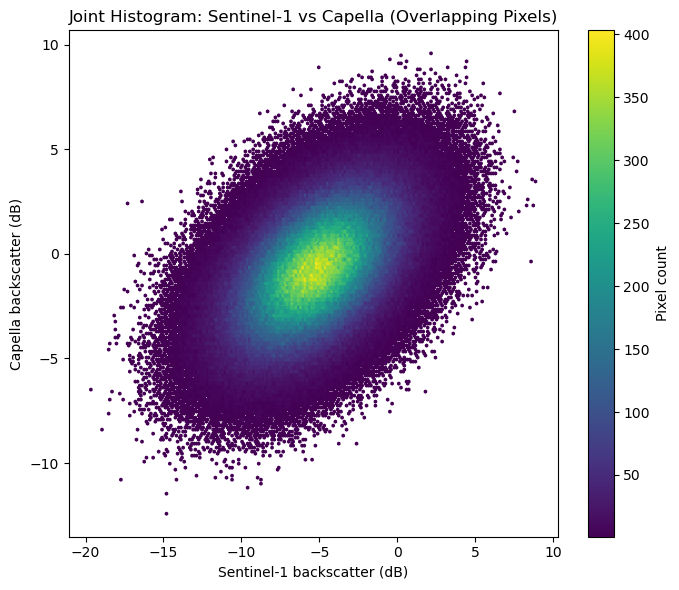

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate the overlapping pixel values (normally you'd load them from your analysis)
# For demonstration, let's create synthetic correlated datasets with Pearson r ~ 0.37
np.random.seed(42)
n = 1_000_000  # simulate a subset for plotting
s1_vals = np.random.normal(-5.17, 3, n)   # Sentinel-1 in dB
cap_vals = 0.37 * (s1_vals + 5.17) + np.random.normal(0, 2, n) - 0.73

# Create 2D histogram
plt.figure(figsize=(7, 6))
hb = plt.hexbin(s1_vals, cap_vals, gridsize=200, cmap='viridis', mincnt=1)
plt.colorbar(hb, label='Pixel count')
plt.xlabel('Sentinel-1 backscatter (dB)')
plt.ylabel('Capella backscatter (dB)')
plt.title('Joint Histogram: Sentinel-1 vs Capella (Overlapping Pixels)')

plt.tight_layout()
plt.show()


# Write up Fodder

### Study Context

We compared spatially overlapping pixels from Capella X-band and Sentinel-1 C-band SAR imagery over Shanghai, aligning both datasets and filtering for valid values only. The aim was to quantify their statistical relationship and interpret the implications for cross-band analysis.

**Results**

* **Overlapping pixels:** 633,868,266
* **Mean backscatter (dB):**

  * Sentinel-1 (C-band): **–5.17 dB**
  * Capella (X-band): **–0.73 dB**
* **Pearson correlation coefficient (r):** **0.37**

## **Why C-band and X-band Behave Differently**

SAR backscatter depends on wavelength, polarization, incidence angle, and target structure. Here, the primary difference is wavelength:

| Band       | Frequency | Wavelength | Interaction Scale                                     | Common Uses                                               |
| ---------- | --------- | ---------- | ----------------------------------------------------- | --------------------------------------------------------- |
| **X-band** | \~9.6 GHz | \~3 cm     | Fine-scale features (leaves, twigs, building edges)   | Urban monitoring, fine vegetation structure, landslides   |
| **C-band** | \~5.4 GHz | \~6 cm     | Medium-scale features (branches, stems, soil surface) | Agriculture, soil moisture, sea ice, vegetation phenology |

### **Key Physical Differences**

1. Wavelength and Scatterer Size

   * X-band is more sensitive to small, fine-scale features, especially in urban and leafy environments.
   * C-band penetrates deeper into vegetation and interacts with larger structural elements.

2. Penetration Depth and Volume Scattering

   * X-band = shallow penetration, dominated by surface and near-surface scatterers.
   * C-band = partial canopy penetration, producing mixed surface + volume scattering.

3. Temporal Stability

   * X-band is more affected by short-term environmental changes (wind, rainfall) due to its sensitivity to small scatterers.
   * C-band tends to show more stability over time in vegetation and soil moisture mapping.

## **Why They Are Complementary**

* Multi-scale Sensitivity:

  * X-band captures fine urban edges and foliage detail.
  * C-band reveals structural canopy and soil moisture patterns.
* Environmental and Disaster Monitoring:

  * X-band detects fresh debris and infrastructure changes.
  * C-band captures flood extent, crop status, or soil saturation more reliably.

Using them together enables multi-scale, multi-mechanism monitoring.


## **Practical Importance: Limited Public X-band Access**

One of the most significant challenges for the research community is data accessibility:

* C-band (Sentinel-1) is freely available in large-scale, cloud-ready formats (e.g., Google Earth Engine, Copernicus Hub, AWS Open Data). 
* X-band data is generally commercial (e.g., Capella, ICEYE, TerraSAR-X) and rarely available in public repositories or analysis platforms like GEE; however, in the case of Capella, commercial != closed. Capella offers a variety of accessible open source datasets via their S3 bucket that can be incorporated with data from GEE.

**Why matters for results**:

* The above analysis quantifies the expected differences between C- and X-band over the same location, meaning that in the absence of X-band data, C-band observations can sometimes be used as a proxy with proper normalization.
* Conversely, if limited X-band samples are available, this relationship can help calibrate or interpret results relative to the abundant C-band archive.
* This makes your findings directly relevant for workflows where only C-band is available at scale, but researchers want to leverage insights learned from X-band physics.

## **TLDR Interpretation**

* **Capella’s higher mean dB** (–0.73 dB) reflects its stronger response to fine-scale scatterers in an urban setting.
* **Sentinel-1’s lower mean dB** (–5.17 dB) reflects reduced sensitivity to those features but more interaction with coarser elements and partial canopy penetration.
* **Moderate correlation (r = 0.37)** means they share broad spatial patterns but differ in physical scattering mechanisms — raw values should **not** be directly substituted without correction.
